<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Colorida_Base3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/




---



In [1]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.




---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido3/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido3/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido3/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Colorido2_rede2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação

## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4361 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [0]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 19.64%, AUC: 0.648, Accuracy: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [13]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [16]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 26s - loss: 0.7520 - acc: 0.4500 - val_loss: 0.6991 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.69909, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_1.hdf5
Epoch 2/50
 - 27s - loss: 0.6944 - acc: 0.4875 - val_loss: 0.7078 - val_acc: 0.4375

Epoch 00002: val_loss did not improve from 0.69909
Epoch 3/50
 - 26s - loss: 0.6973 - acc: 0.4875 - val_loss: 0.7060 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 0.69909
Epoch 4/50
 - 28s - loss: 0.6884 - acc: 0.5750 - val_loss: 0.6891 - val_acc: 0.6562

Epoch 00004: val_loss improved from 0.69909 to 0.68913, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_1.hdf5
Epoch 5/50
 - 25s - loss: 0.6761 - acc: 0.5687 - val_loss: 0.7124 - val_acc: 0.4688

Epoch 00005: val_loss did not improve from 0.68913
Epoch 6/50
 - 26s - loss: 0.7090 - acc: 0.4562 - val_loss: 0.6886 - val_acc: 0.5938

Epoch 00006

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

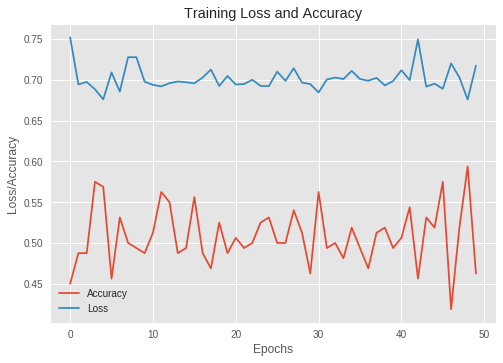

In [18]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [19]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [20]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.648, Accuracy: 19.64%


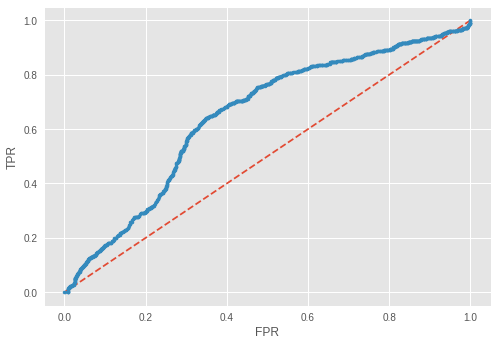

In [21]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa  - Test Precision: 61.63%, AUC: 0.873, Accuracy: 85.46%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [26]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6927 - acc: 0.5062 - val_loss: 0.6928 - val_acc: 0.4516

Epoch 00001: val_loss improved from inf to 0.69282, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6905 - acc: 0.5938 - val_loss: 0.6901 - val_acc: 0.6250

Epoch 00002: val_loss improved from 0.69282 to 0.69005, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6920 - acc: 0.5125 - val_loss: 0.6921 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69005
Epoch 4/50
 - 1s - loss: 0.6932 - acc: 0.4750 - val_loss: 0.6934 - val_acc: 0.4375

Epoch 00004: val_loss did not improve from 0.69005
Epoch 5/50
 - 1s - loss: 0.6919 - acc: 0.5039 - val_loss: 0.6926 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.69005
Epoch 6/50
 - 1s - loss: 0.6909 - acc: 0.5125 - val_loss: 0.6938 - val_acc: 0.4062

Epoch 00006: val_loss did not improve from 0.69005
Epoch 7/50
 - 

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

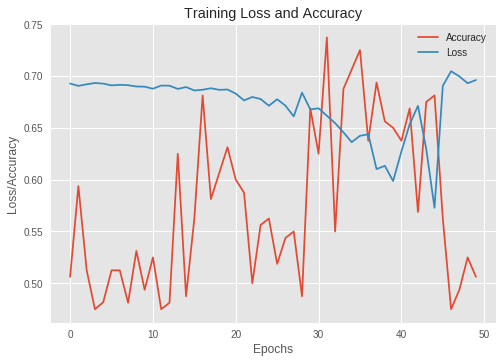

In [28]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [29]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [30]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 61.63%, AUC: 0.873, Accuracy: 85.46%


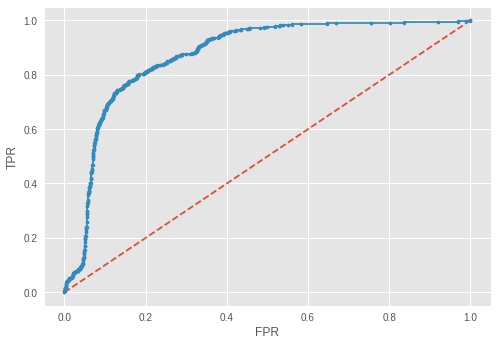

In [31]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 46.46%, AUC: 0.781, Accuracy: 78.60%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [36]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
 - 4s - loss: 2.7938 - acc: 0.4875 - val_loss: 0.7341 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 0.73409, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 1.8984 - acc: 0.4875 - val_loss: 0.7048 - val_acc: 0.6452

Epoch 00002: val_loss improved from 0.73409 to 0.70480, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_3.hdf5
Epoch 3/50
 - 0s - loss: 1.2039 - acc: 0.5219 - val_loss: 0.7527 - val_acc: 0.5156

Epoch 00003: val_loss did not improve from 0.70480
Epoch 4/50
 - 0s - loss: 0.8619 - acc: 0.5781 - val_loss: 0.7905 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.70480
Epoch 5/50
 - 0s - loss: 0.7607 - acc: 0.6312 - val_loss: 0.6240 - val_acc: 0.7031

Epoch 00005: val_loss improved from 0.70480 to 0.62402, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_a

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

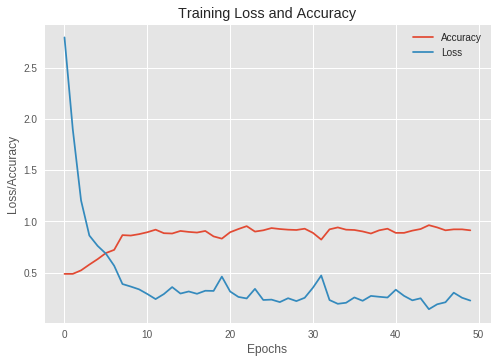

In [38]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [39]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [40]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 46.46%, AUC: 0.781, Accuracy: 78.60%


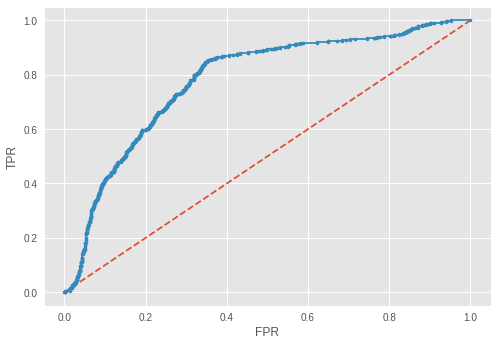

In [41]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 39.32%, AUC: 0.751, Accuracy: 79.60%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [46]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.8696 - acc: 0.4937 - val_loss: 1.3844 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 1.38435, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.7094 - acc: 0.6188 - val_loss: 1.6009 - val_acc: 0.4844

Epoch 00002: val_loss did not improve from 1.38435
Epoch 3/50
 - 0s - loss: 0.6159 - acc: 0.7031 - val_loss: 0.9348 - val_acc: 0.6452

Epoch 00003: val_loss improved from 1.38435 to 0.93477, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_4.hdf5
Epoch 4/50
 - 0s - loss: 0.4864 - acc: 0.7812 - val_loss: 0.5657 - val_acc: 0.7812

Epoch 00004: val_loss improved from 0.93477 to 0.56574, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_4.hdf5
Epoch 5/50
 - 0s - loss: 0.3881 - acc: 0.8594 - val_loss: 0.5526 - val_acc: 0.7656

Epoch 00005: val_loss improved from 0.56574 to 0.55261, saving model to drive/My Drive/Resultado/Colorido2_red

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

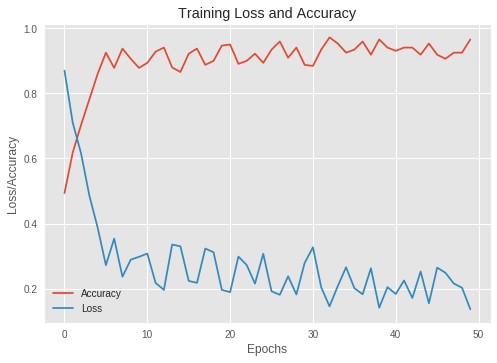

In [48]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [49]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [50]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 39.32%, AUC: 0.751, Accuracy: 79.60%


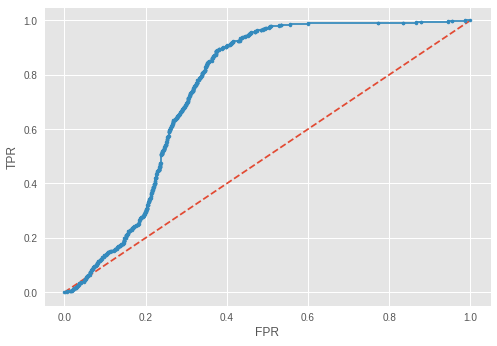

In [51]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 47.64%, AUC: 0.881, Accuracy: 78.69%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [56]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 3.0797 - acc: 0.4719 - val_loss: 2.7563 - val_acc: 0.3125

Epoch 00001: val_loss improved from inf to 2.75632, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 2.3159 - acc: 0.4594 - val_loss: 0.7550 - val_acc: 0.5000

Epoch 00002: val_loss improved from 2.75632 to 0.75497, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 1.7705 - acc: 0.4312 - val_loss: 0.8317 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 0.75497
Epoch 4/50
 - 0s - loss: 1.0336 - acc: 0.5375 - val_loss: 0.7542 - val_acc: 0.5484

Epoch 00004: val_loss improved from 0.75497 to 0.75416, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_5.hdf5
Epoch 5/50
 - 0s - loss: 0.9853 - acc: 0.4719 - val_loss: 0.6865 - val_acc: 0.6562

Epoch 00005: val_loss improved from 0.75416 to 0.68647, saving model to drive/My Drive/Resultado/Colorido2_red

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

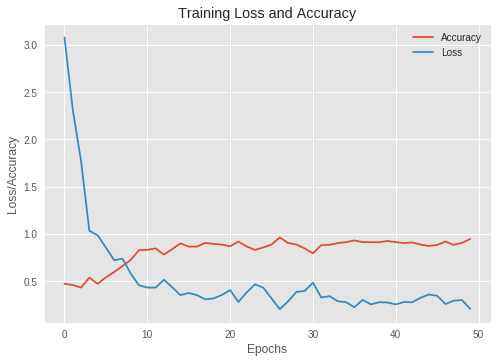

In [58]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [59]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [60]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 47.64%, AUC: 0.881, Accuracy: 78.69%


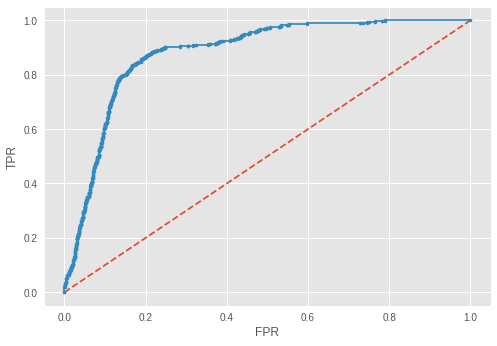

In [61]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 0.00%, AUC: 0.924, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [66]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.8798 - acc: 0.4937 - val_loss: 1.4880 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.48802, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.7803 - acc: 0.5312 - val_loss: 0.9309 - val_acc: 0.5000

Epoch 00002: val_loss improved from 1.48802 to 0.93092, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.7378 - acc: 0.5531 - val_loss: 0.7280 - val_acc: 0.5781

Epoch 00003: val_loss improved from 0.93092 to 0.72804, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_6.hdf5
Epoch 4/50
 - 0s - loss: 0.6868 - acc: 0.6781 - val_loss: 1.5158 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.72804
Epoch 5/50
 - 0s - loss: 0.5574 - acc: 0.7969 - val_loss: 1.3392 - val_acc: 0.4194

Epoch 00005: val_loss did not improve from 0.72804
Epoch 6/50
 - 0s - loss: 0.5112 - acc: 0.8094 - val_loss: 1

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

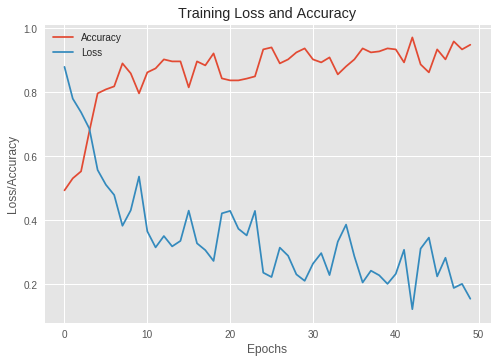

In [68]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [69]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [70]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.924, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


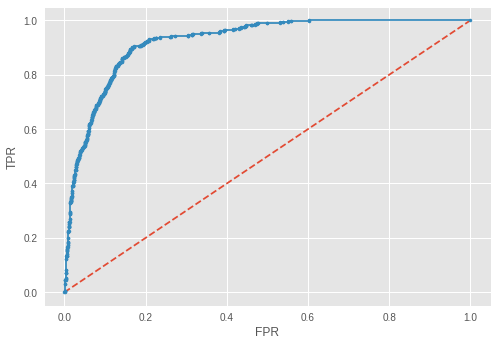

In [71]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 0.00%, AUC: 0.865, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [76]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.8258 - acc: 0.5344 - val_loss: 0.9569 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 0.95689, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.6554 - acc: 0.6937 - val_loss: 0.7754 - val_acc: 0.6719

Epoch 00002: val_loss improved from 0.95689 to 0.77539, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_7.hdf5
Epoch 3/50
 - 0s - loss: 0.4581 - acc: 0.8250 - val_loss: 0.5052 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.77539 to 0.50523, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_7.hdf5
Epoch 4/50
 - 0s - loss: 0.3191 - acc: 0.8844 - val_loss: 0.8235 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.50523
Epoch 5/50
 - 0s - loss: 0.3282 - acc: 0.9062 - val_loss: 0.3713 - val_acc: 0.8906

Epoch 00005: val_loss improved from 0.50523 to 0.37126, saving model to drive/My Drive/Resultado/Colorido2_red

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

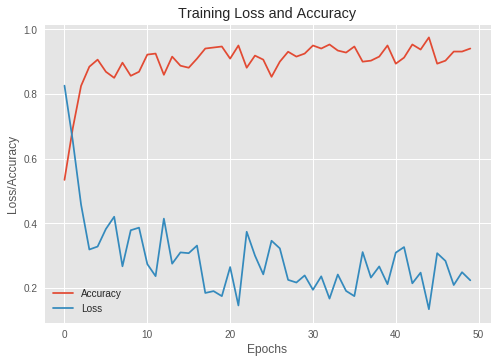

In [78]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [79]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [80]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.865, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


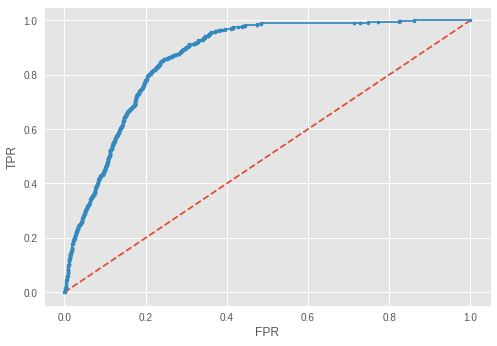

In [81]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa  - Test Precision: 53.83%, AUC: 0.849, Accuracy: 82.30%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [86]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.9823 - acc: 0.5281 - val_loss: 1.2922 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.29225, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 2.2650 - acc: 0.5125 - val_loss: 0.6720 - val_acc: 0.6406

Epoch 00002: val_loss improved from 1.29225 to 0.67200, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_8.hdf5
Epoch 3/50
 - 0s - loss: 1.0888 - acc: 0.5875 - val_loss: 0.8493 - val_acc: 0.4688

Epoch 00003: val_loss did not improve from 0.67200
Epoch 4/50
 - 0s - loss: 0.9520 - acc: 0.6531 - val_loss: 0.5339 - val_acc: 0.7812

Epoch 00004: val_loss improved from 0.67200 to 0.53388, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_8.hdf5
Epoch 5/50
 - 0s - loss: 0.8908 - acc: 0.6932 - val_loss: 0.5348 - val_acc: 0.7812

Epoch 00005: val_loss did not improve from 0.53388
Epoch 6/50
 - 0s - loss: 0.7087 - acc: 0.7500 - val_loss: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

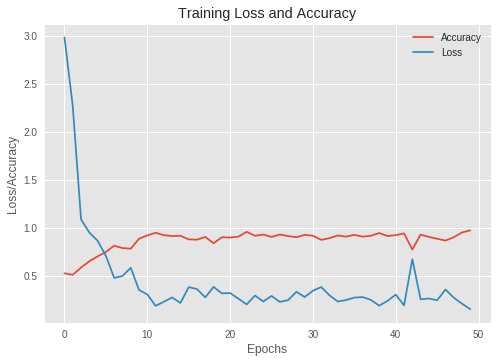

In [88]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [89]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [90]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 53.83%, AUC: 0.849, Accuracy: 82.30%


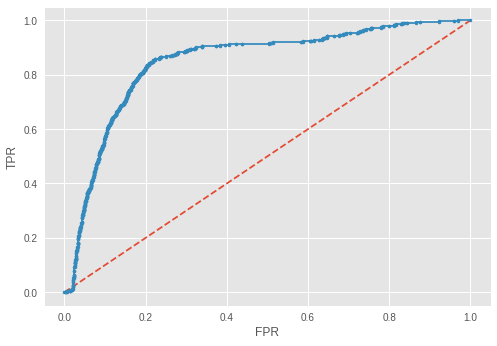

In [91]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 43.47%, AUC: 0.900, Accuracy: 74.65%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [96]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 5.2297 - acc: 0.5312 - val_loss: 1.5425 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 1.54252, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 3.4047 - acc: 0.5750 - val_loss: 1.8452 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 1.54252
Epoch 3/50
 - 0s - loss: 1.5454 - acc: 0.5187 - val_loss: 0.7419 - val_acc: 0.4688

Epoch 00003: val_loss improved from 1.54252 to 0.74195, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_9.hdf5
Epoch 4/50
 - 0s - loss: 0.7246 - acc: 0.5719 - val_loss: 0.7067 - val_acc: 0.5625

Epoch 00004: val_loss improved from 0.74195 to 0.70667, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 0.6873 - acc: 0.6469 - val_loss: 0.6621 - val_acc: 0.7031

Epoch 00005: val_loss improved from 0.70667 to 0.66215, saving model to drive/My Drive/Resultado/Colorido2_red

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

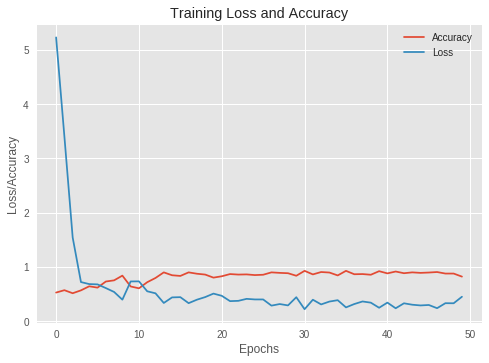

In [98]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [99]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [100]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 43.47%, AUC: 0.900, Accuracy: 74.65%


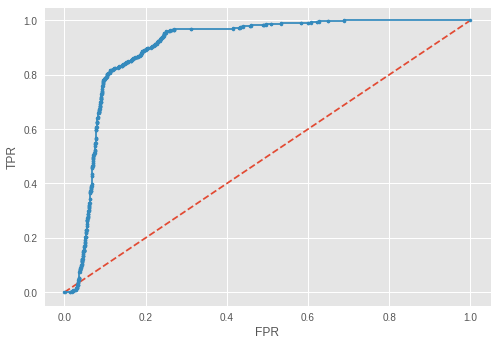

In [101]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 45.58%, AUC: 0.694, Accuracy: 79.14%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [106]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.4346 - acc: 0.5125 - val_loss: 0.7942 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 0.79419, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.3792 - acc: 0.5719 - val_loss: 0.7881 - val_acc: 0.5312

Epoch 00002: val_loss improved from 0.79419 to 0.78809, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 1.2265 - acc: 0.5406 - val_loss: 0.8492 - val_acc: 0.5469

Epoch 00003: val_loss did not improve from 0.78809
Epoch 4/50
 - 1s - loss: 0.8596 - acc: 0.6312 - val_loss: 0.6467 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.78809 to 0.64671, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.6200 - acc: 0.7844 - val_loss: 0.4785 - val_acc: 0.8438

Epoch 00005: val_loss improved from 0.64671 to 0.47851, saving model to drive/My Drive/Resultado/Colorido2_

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

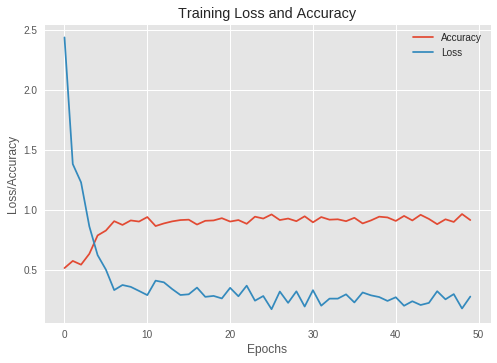

In [108]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [109]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [110]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 45.58%, AUC: 0.694, Accuracy: 79.14%


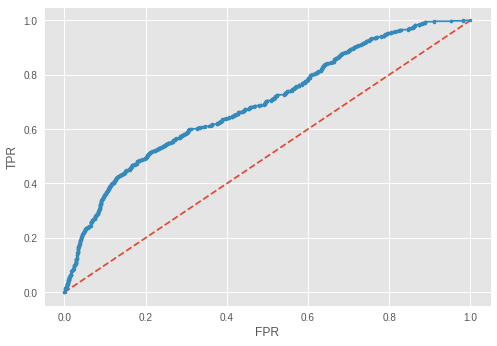

In [111]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 27.69%, AUC: 0.699, Accuracy: 57.32%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [116]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.1593 - acc: 0.4813 - val_loss: 1.0298 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 1.02980, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.6367 - acc: 0.5250 - val_loss: 1.1507 - val_acc: 0.4062

Epoch 00002: val_loss did not improve from 1.02980
Epoch 3/50
 - 1s - loss: 1.9289 - acc: 0.4594 - val_loss: 0.7626 - val_acc: 0.5625

Epoch 00003: val_loss improved from 1.02980 to 0.76265, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.9450 - acc: 0.5844 - val_loss: 0.7357 - val_acc: 0.6094

Epoch 00004: val_loss improved from 0.76265 to 0.73571, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.9084 - acc: 0.5875 - val_loss: 0.6391 - val_acc: 0.7500

Epoch 00005: val_loss improved from 0.73571 to 0.63914, saving model to drive/My Drive/Resultado/Colorido2_

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

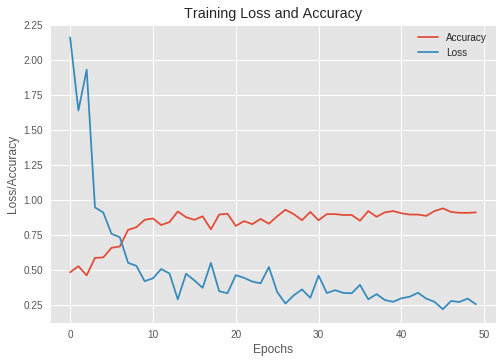

In [118]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [119]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [120]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 27.69%, AUC: 0.699, Accuracy: 57.32%


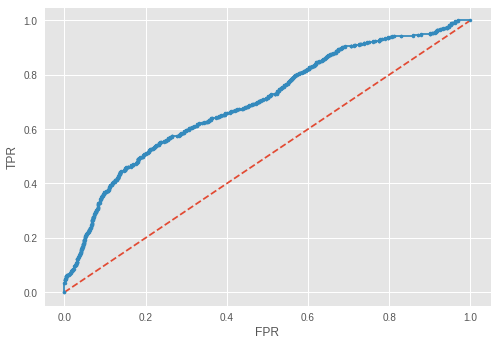

In [121]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 42.99%, AUC: 0.812, Accuracy: 77.08%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [126]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 2.3162 - acc: 0.4719 - val_loss: 0.9007 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 0.90068, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.5937 - acc: 0.4906 - val_loss: 0.7128 - val_acc: 0.4688

Epoch 00002: val_loss improved from 0.90068 to 0.71283, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.0916 - acc: 0.5062 - val_loss: 0.7519 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 0.71283
Epoch 4/50
 - 1s - loss: 0.9779 - acc: 0.5438 - val_loss: 0.5834 - val_acc: 0.7656

Epoch 00004: val_loss improved from 0.71283 to 0.58339, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.6312 - acc: 0.6750 - val_loss: 0.5242 - val_acc: 0.8750

Epoch 00005: val_loss improved from 0.58339 to 0.52423, saving model to drive/My Drive/Resultado/Colorido2_

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

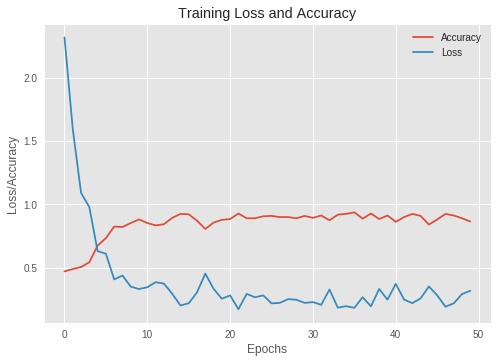

In [128]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [129]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [130]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 42.99%, AUC: 0.812, Accuracy: 77.08%


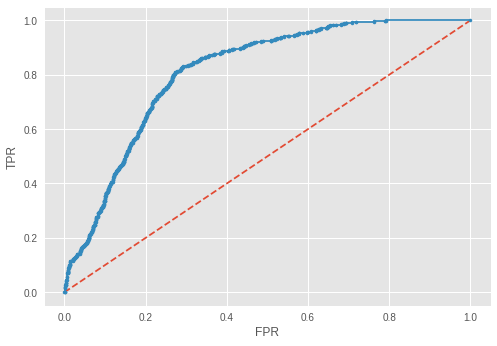

In [131]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 46.83%, AUC: 0.777, Accuracy: 78.81%

Modelo adaptado do ** Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [136]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.1537 - acc: 0.5625 - val_loss: 0.7255 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.72546, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.5891 - acc: 0.7500 - val_loss: 0.4210 - val_acc: 0.7969

Epoch 00002: val_loss improved from 0.72546 to 0.42104, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.3185 - acc: 0.8875 - val_loss: 1.2417 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.42104
Epoch 4/50
 - 0s - loss: 0.4146 - acc: 0.8625 - val_loss: 0.4726 - val_acc: 0.8438

Epoch 00004: val_loss did not improve from 0.42104
Epoch 5/50
 - 1s - loss: 0.4067 - acc: 0.8500 - val_loss: 1.1335 - val_acc: 0.7188

Epoch 00005: val_loss did not improve from 0.42104
Epoch 6/50
 - 1s - loss: 0.5001 - acc: 0.8500 - val_loss: 2.3019 - val_acc: 0.4062

Epoch 00006: val_loss did not improve from 0.42104
Epoch 7/50
 

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

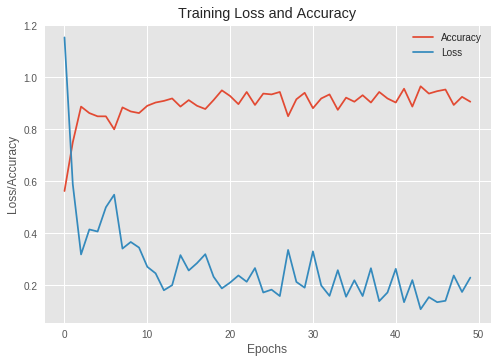

In [138]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [139]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [140]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 46.83%, AUC: 0.777, Accuracy: 78.81%


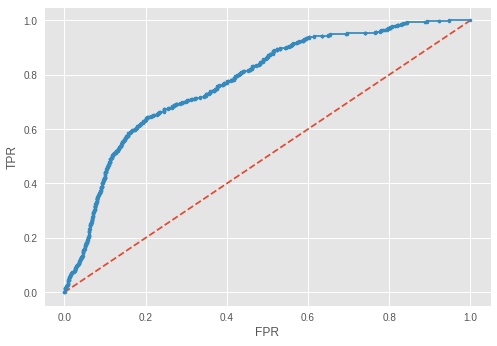

In [141]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## Mini VGG - Test Precision: 56.17%, AUC: 0.897, Accuracy: 84.24%

In [0]:
architecture = 'miniVGG_base2_colorida'

### Modelo

In [0]:
def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  # return the constructed network architecture
  return model

In [0]:
model = build_MiniVGG(width=120, height=120, depth=3, classes=2)

opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

### Treino

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido2_rede2/' + 
                               'weights_' + architecture + '.hdf5', verbose=1,
                               save_best_only=True)

In [146]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.0043 - acc: 0.6500 - val_loss: 3.5428 - val_acc: 0.5312

Epoch 00001: val_loss improved from inf to 3.54278, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_miniVGG_base2_colorida.hdf5
Epoch 2/50
 - 1s - loss: 0.9625 - acc: 0.7875 - val_loss: 4.1786 - val_acc: 0.5625

Epoch 00002: val_loss did not improve from 3.54278
Epoch 3/50
 - 1s - loss: 0.6912 - acc: 0.7313 - val_loss: 1.1026 - val_acc: 0.6562

Epoch 00003: val_loss improved from 3.54278 to 1.10257, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_miniVGG_base2_colorida.hdf5
Epoch 4/50
 - 1s - loss: 0.3575 - acc: 0.8688 - val_loss: 0.7294 - val_acc: 0.8438

Epoch 00004: val_loss improved from 1.10257 to 0.72942, saving model to drive/My Drive/Resultado/Colorido2_rede2/weights_miniVGG_base2_colorida.hdf5
Epoch 5/50
 - 1s - loss: 0.4913 - acc: 0.8256 - val_loss: 0.9639 - val_acc: 0.7812

Epoch 00005: val_loss did not improve from 0.72942
Epoch 6/50
 - 1s - loss: 0.4219 - a

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido2_rede2/weights_' + architecture + '.hdf5')

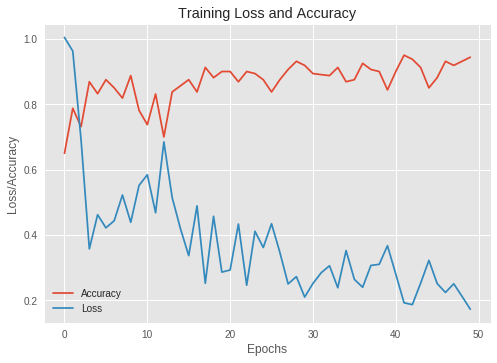

In [148]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [149]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [150]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 56.17%, AUC: 0.897, Accuracy: 84.24%


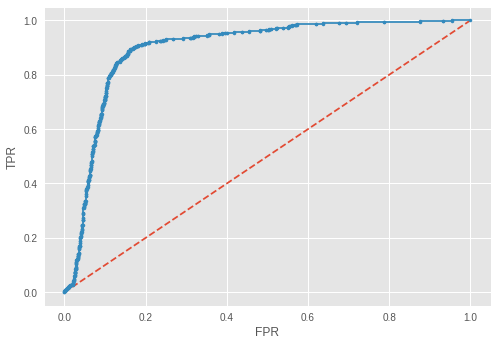

In [151]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido2_rede2/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')